# Descriptive analysis

In [14]:
%matplotlib inline

import IPython.display as ipd
import numpy as np
import pandas as pd
import pickle 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils
import sklearn.preprocessing
import sklearn.decomposition
import re
import folium

from folium.plugins import MarkerCluster
from matplotlib import cm
from scipy.stats import norm
from mpl_toolkits.basemap import Basemap

import utils
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18, 8)
plt.rcParams["legend.facecolor"] = "white"
plt.rcParams["legend.borderpad"] = 1
pallete_colors = cm.get_cmap('Set3', 16)
subset_size = "large"

In [15]:
# Loading data created in first notebook and preporcessing
file_tracks =  open('../data/fma_metadata/tracks.pkl', 'rb') 
tracks = pickle.load(file_tracks)
file_features =  open('../data/fma_metadata/features.pkl', 'rb') 
features = pickle.load(file_features)
genres = utils.load('../data/fma_metadata/genres.csv')

## 1 Size

In [ ]:
print('{} tracks, {} artists, {} albums, {} genres'.format(
    len(tracks), len(tracks['artist', 'id'].unique()),
    len(tracks['album', 'id'].unique()),
    sum(genres['#tracks'] > 0)))
mean_duration = tracks['track', 'duration'].mean()
print('track duration: {:.0f} days total, {:.0f} seconds average'.format(
    sum(tracks['track', 'duration']) / 3600 / 24,
    mean_duration))

In [4]:
dimensionality = mean_duration * 44000 * 2
print('sample dimensionality: {:.1e}'.format(dimensionality))
print('total size, i.e. number of audio samples: {:.1e}'.format(dimensionality * len(tracks)))

sample dimensionality: 2.4e+07
total size, i.e. number of audio samples: 2.5e+12


In [5]:
indicator = tracks['set', 'subset'] <= subset_size
print('Subset{:6}: {:6} tracks  {:.1f} days'.format(
subset_size, sum(indicator), sum(indicator) * 30 / 3600 / 24))

Subsetlarge : 104343 tracks  36.2 days


50977 deleted tracks (largest track_id is 155320)
First track: 2008-11-25 17:49:06


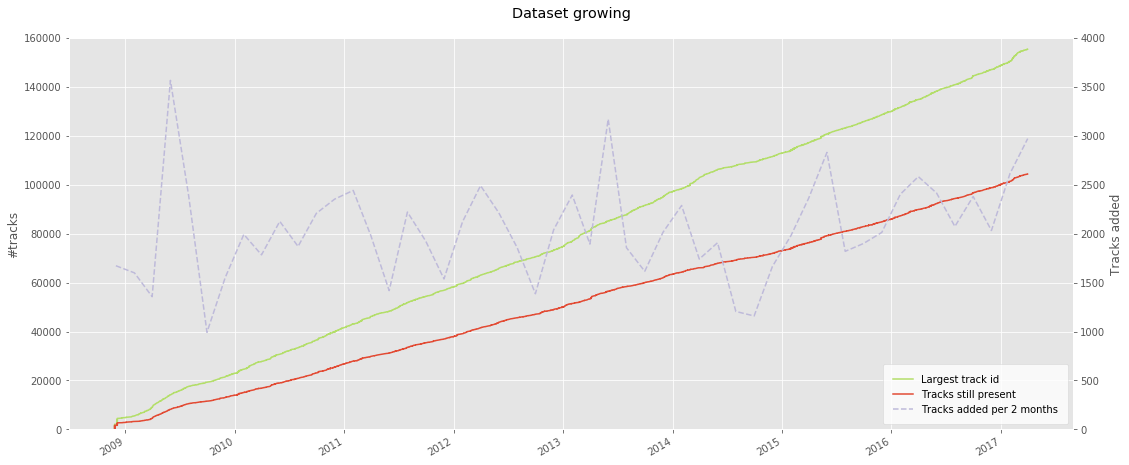

In [495]:
print('{} deleted tracks (largest track_id is {})'.format(tracks.index.max() - len(tracks), tracks.index.max()))
print('First track: {}'.format(tracks['track', 'date_created'].min()))

d = pd.DataFrame(tracks.index, index=tracks['track', 'date_created'].values)
d['indicator'] = 1

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

d['track_id'].plot(ax=ax1, style=matplotlib.colors.to_hex((pallete_colors(8))))
d['indicator'].cumsum().plot(ax=ax1)
ax1.set_ylabel('Tracks')
ax1.set_ylim(0, 160000)

(d['indicator'] * -100).plot(ax=ax2, color=pallete_colors(2))  # needed for no apparent reason
d['indicator'].resample('2M').sum().fillna(0).plot(ax=ax2, style='--', color=pallete_colors(3))
ax2.set_ylabel('Tracks added')
ax2.set_ylim(500, 4500)
ax2.set_ylim(0, 4000)
ax2.grid(False)

plt.title("Dataset growing", pad=20)
lns = ax1.get_lines() + [ax2.get_lines()[1]]
ax1.legend(lns, ['Largest track id', 'Tracks still present', 'Tracks added per 2 months'], loc='lower right')

plt.savefig('graphs/growth.png')

### 1.1 Splits

In [39]:
SPLITS = ['training', 'validation', 'test']
SUBSETS = ['small', 'medium', 'large']
print('subset    #train    #val   #test  val_ratio test_ratio')
for subset in SUBSETS:
    counts = [sum((tracks['set', 'split'] == split) & 
                  (tracks['set', 'subset'] <= subset)) for split in SPLITS]
    ratios = [counts[0] / x for x in  counts[1:]]
    print('{:8s} {:7d} {:7d} {:7d} {:8.2f} {:9.2f}'.format(subset, *counts, *ratios))

subset    #train    #val   #test  val_ratio test_ratio
small       6400     800     800     8.00      8.00
medium     19922    2505    2573     7.95      7.74
large      82374   10848   11121     7.59      7.41


In [497]:
subset = tracks['set', 'subset'] <= subset_size

d = genres.reset_index().set_index('title')
d = d.loc[tracks.loc[subset, ('track', 'genre_top')].unique()]

for split in SPLITS:
    b = tracks['set', 'split'] == split
    d['#' + split] = tracks.loc[subset & b,
                                ('track', 'genre_top')].value_counts()

d['val_ratio'] = d['#training'] / d['#validation']
d['test_ratio'] = d['#training'] / d['#test']
d = d.sort_values('#tracks', ascending=False)
d.reset_index(level=0, inplace=True)
d

title  genre_id  #tracks  parent  top_level  #training  \
0          Experimental        38    38154       0         38      22401   
1            Electronic        15    34413       0         15      12536   
2                  Rock        12    32923       0         12      18302   
3          Instrumental      1235    14938       0       1235       5331   
4                   Pop        10    13845       0         10       5454   
5                  Folk        17    12706       0         17       5115   
6               Hip-Hop        21     8389       0         21       4633   
7         International         2     5271       0          2       2552   
8                  Jazz         4     4126       0          4        784   
9             Classical         5     4106       0          5       1723   
10              Country         9     1987       0          9        914   
11               Spoken        20     1876       0         20        663   
12                Blues         3     1752       0          3        323   
13             Soul-RnB        14     1499       0         14        901   
14  Old-Time / Historic         8      868       0          8        486   
15       Easy Listening        13      730       0         13        256   

    #validation  #test  val_ratio  test_ratio  
0          3173   2894   7.059880    7.740498  
1          1818   1636   6.895490    7.662592  
2          2240   2354   8.170536    7.774851  
3           717    934   7.435146    5.707709  
4           701    819   7.780314    6.659341  
5           558    586   9.166667    8.728669  
6           591    626   7.839255    7.400958  
7           298    360   8.563758    7.088889  
8            77    132  10.181818    5.939394  
9           210    267   8.204762    6.453184  
10           94    145   9.723404    6.303448  
11          164     62   4.042683   10.693548  
12           13     94  24.846154    3.436170  
13          109    102   8.266055    8.833333  
14           54     66   9.000000    7.363636  
15           31     44   8.258065    5.818182

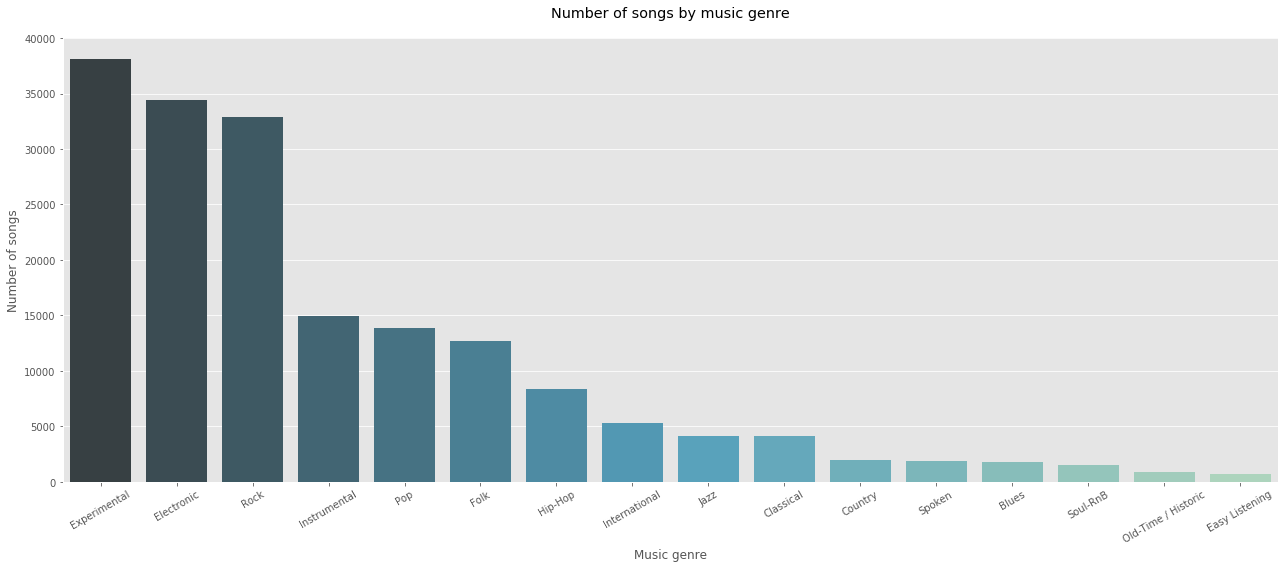

In [499]:
g = sns.barplot(d['title'], d['#tracks'], palette=("GnBu_d"))
g.set_xticklabels(rotation=30, labels=d['title'])
g.set(xlabel='Music genre', ylabel='Number of songs')
g.set_title('Number of songs by music genre', pad=20)
g.get_figure().tight_layout()
g.get_figure().savefig('graphs/tracks-genre.png')

## 2 Metadata

In [42]:
def isnull(column, df=tracks):
    if column[1] in ['tags', 'genres', 'genres_all']:
        return df[column].apply(lambda x: len(x) == 0)
    elif df.dtypes[column] == np.int:
        return df[column] <= 0
    else:
        return df[column].isnull()


def count(series):
    col0 = series.name[0]
    df = tracks if col0 == 'track' else tracks.drop_duplicates((col0, 'id'))
    n = (~isnull(series.name, df)).sum()
    p = round(n / len(df) * 100, 2)
    return n, p


# Columns / metadata usage across dataset.
d = pd.DataFrame(index=tracks.columns.drop('set'), columns=['n', 'p'])
d = d.apply(count, axis=1)

ipd.display(pd.DataFrame(d, columns=["(count, %)"]))

(count, %)
album  comments            (14349, 100.0)
       date_created         (13961, 97.3)
       date_released        (9292, 64.76)
       engineer             (2299, 16.02)
       favorites           (14349, 100.0)
       id                  (14349, 100.0)
       information         (11070, 77.15)
       listens             (14349, 100.0)
       producer             (2571, 17.92)
       tags                 (2605, 18.15)
       title               (14348, 99.99)
       tracks              (14349, 100.0)
       type                (13535, 94.33)
artist active_year_begin     (1236, 7.93)
       active_year_end        (318, 2.04)
       associated_labels      (851, 5.46)
       bio                  (5930, 38.03)
       comments            (15595, 100.0)
       date_created        (15394, 98.71)
       favorites           (15595, 100.0)
       id                  (15595, 100.0)
       latitude             (3734, 23.94)
       location             (5892, 37.78)
       longitude            (3734, 23.94)
       members              (3966, 25.43)
       name                (15595, 100.0)
       related_projects        (748, 4.8)
       tags                 (15080, 96.7)
       website              (6707, 43.01)
       wikipedia_page         (386, 2.48)
track  bit_rate           (104343, 100.0)
       comments           (104343, 100.0)
       composer              (3659, 3.51)
       date_created       (104343, 100.0)
       date_recorded         (6131, 5.88)
       duration           (104343, 100.0)
       favorites          (104343, 100.0)
       genre_top          (104343, 100.0)
       genres             (104343, 100.0)
       genres_all         (104343, 100.0)
       information           (2228, 2.14)
       interest           (104343, 100.0)
       language_code       (14797, 14.18)
       license            (104256, 99.92)
       listens            (104343, 100.0)
       lyricist                (310, 0.3)
       number             (104343, 100.0)
       publisher              (1257, 1.2)
       tags                (23039, 22.08)
       title              (104342, 100.0)

In [43]:
tracks['track', 'license'].value_counts().head(10)

Attribution-Noncommercial-Share Alike 3.0 United States                          18883
Attribution-NonCommercial-NoDerivatives (aka Music Sharing) 3.0 International    17377
Attribution-NonCommercial-ShareAlike 3.0 International                           15018
Creative Commons Attribution-NonCommercial-NoDerivatives 4.0                     11902
Attribution-Noncommercial-No Derivative Works 3.0 United States                  10402
Attribution-NonCommercial-ShareAlike                                              6854
Attribution                                                                       4705
Attribution-NonCommercial 3.0 International                                       3503
Attribution-NonCommercial                                                         3347
Attribution-ShareAlike                                                            1496
Name: (track, license), dtype: int64

In [433]:
data_lang = pd.DataFrame(tracks['track',
                                'language_code'].value_counts().head(10))
data_lang = data_lang.sort_values(('track', 'language_code'), ascending=False)
data_lang.reset_index(level=0, inplace=True)
data_lang.columns = ["lan", "count"]
data_lang['porcentual'] = round(data_lang["count"] / data_lang["count"].sum(),
                                2)

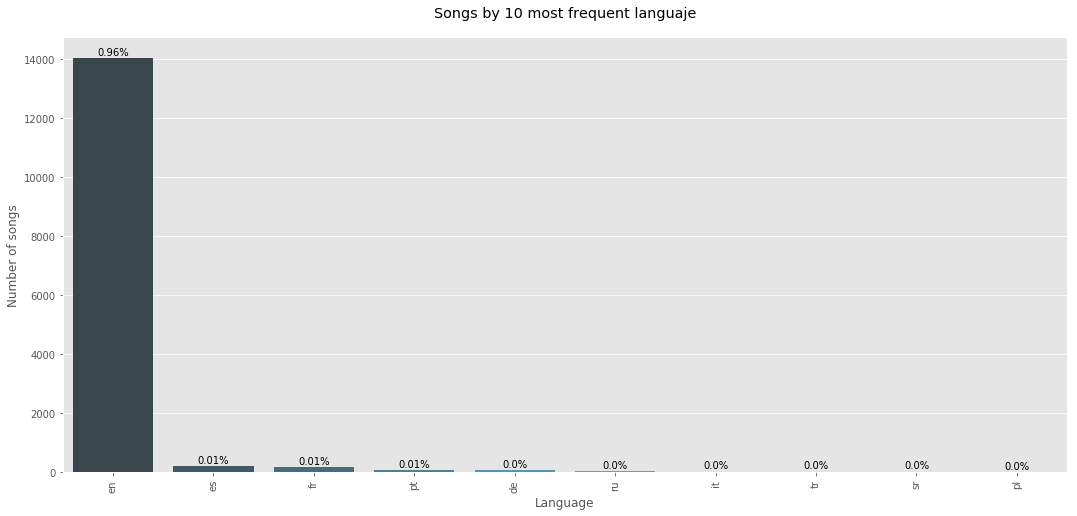

In [501]:
g = sns.barplot(data_lang['lan'], data_lang['count'], palette="GnBu_d")
g.set_xticklabels(rotation=90, labels=data_lang['lan'])
g.set(xlabel='Language', ylabel='Number of songs')
g.set_title('Songs by 10 most frequent languaje', pad=20)

for index, row in data_lang.iterrows():
    plt.text(index, row['count']+100, str(row['porcentual']) + "%",
             color='black', ha="center")

g.get_figure().savefig('graphs/tracks-language.png')

### 2.1 Location data

In [3]:
col_map = [("track", "genre_top"),
           ("artist", "latitude"),
           ("artist", "longitude")]
location_data = tracks[tracks['artist',
                              'latitude'].notnull()].loc[:, col_map]
location_data.columns = ["genre_top", "lat", "lng"]

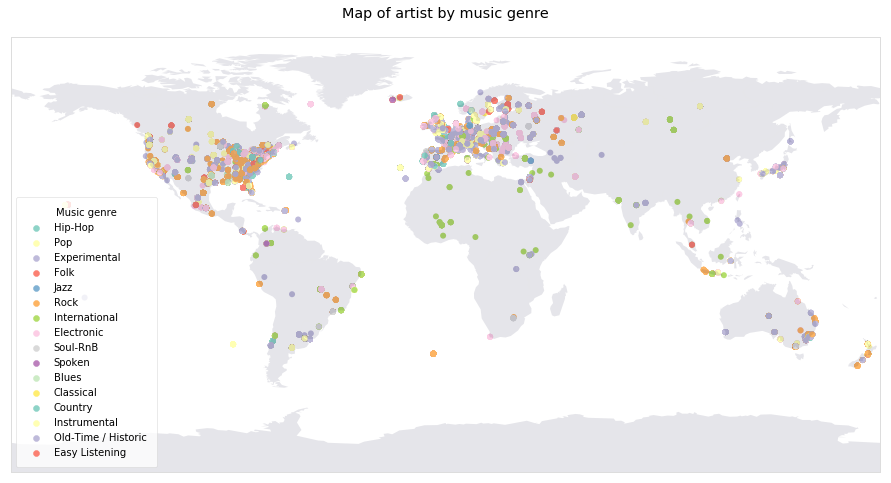

In [105]:
import matplotlib.pyplot as plt

palette = sns.color_palette("Set3", 16)
m = Basemap( llcrnrlat=-90,
             urcrnrlat=90,
             llcrnrlon=-180,
             urcrnrlon=180,
             lat_ts=0,)
m.fillcontinents(color='#000033', alpha=0.1)
m.drawmapboundary(color='#eeeeee')
g = sns.scatterplot(x="lng", y="lat",
                    hue=list(location_data['genre_top']),
                    data=location_data,
                    linewidth=0,
                    alpha=1,
                    palette=palette,)
g.set_facecolor('white')
for spine in g.spines.values():
        spine.set_edgecolor('#dddddd')
plt.tick_params(top=False, bottom=False,
                left=False, right=False,
                labelleft=False, labelbottom=False)
g.set_title("Map of artist by music genre", pad=20)
g.set_ylabel('')
g.set_xlabel('')
plt.legend(title='Music genre')

g.get_figure().savefig('graphs/map-artist.png')

In [316]:
map_al = folium.Map(height=500, location=[30,0], zoom_start=2)
                         
mc = MarkerCluster()

for idx, row in location_data[0:2000].iterrows():
    mc.add_child(folium.Marker(location=[row.lat,  row.lng],
                 popup=row.genre_top))

map_al.add_child(mc)

### 2.2 Technical data

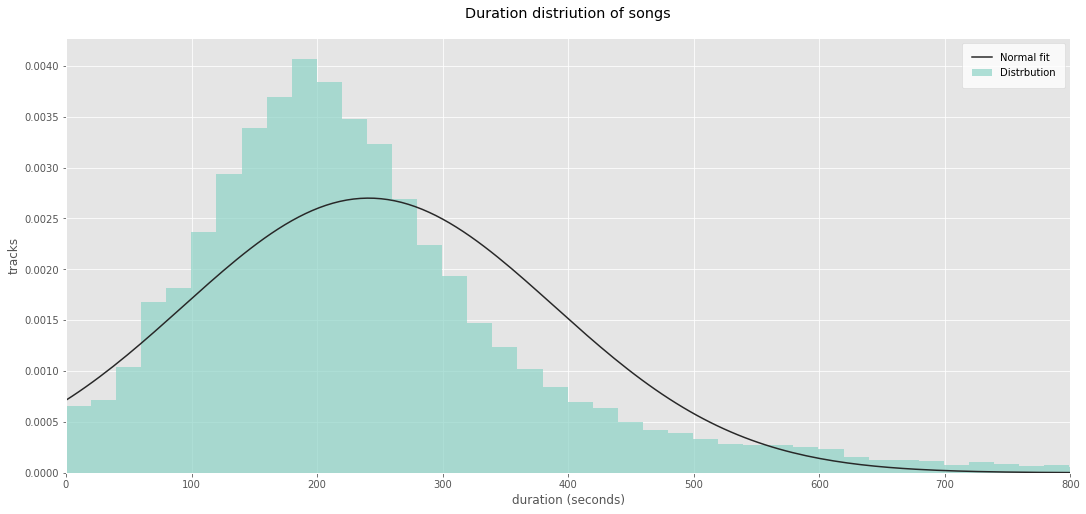

In [16]:
durations = tracks['track', 'duration']
g = sns.distplot(durations[durations.values < 1000],
                 kde=False, rug=False, color=pallete_colors(1),
                 hist_kws={"alpha": 0.7},
                 fit=norm)
g.set_title("Duration distriution of songs", pad="20")
g.set_xlabel('duration (seconds)')
g.legend(labels=['Normal fit', 'Distrbution'])

g.set_ylabel('tracks')
g.set_xlim(0, 800)

plt.savefig('graphs/duration_distribution.png')

Common bit rates: [320000, 256000, 192000, 128000, 160000]
Average bit rate: 264 kbit/s


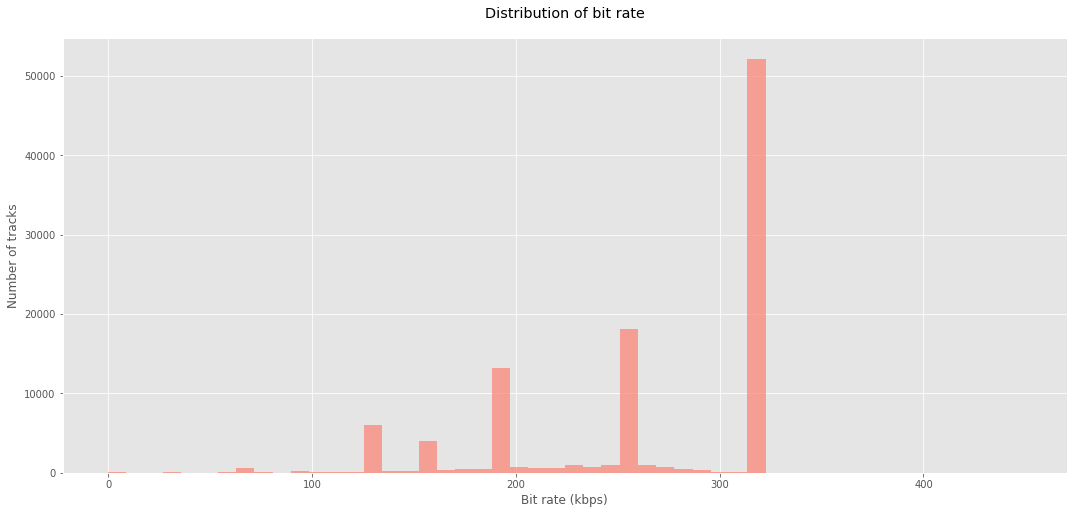

In [516]:
# Uncommon bit rates are VBR encodings. (Dinámico a través del tiempo)
print('Common bit rates: {}'.format(tracks['track',
                                           'bit_rate'].value_counts().head(5).index.tolist()))
print('Average bit rate: {:.0f} kbit/s'.format(tracks['track',
                                                      'bit_rate'].mean()/1000))
g = sns.distplot(tracks['track', 'bit_rate']/1000, rug=False,
                 kde=False, hist_kws={"alpha": 0.7},
                 color=pallete_colors(4))
g.set_title("Distribution of bit rate", pad=20)
g.set_xlabel('Bit rate (kbps)')
g.set_ylabel('Number of tracks')

plt.savefig('graphs/bitrate_distribution.png')

### 2.2 User data

0 150
0 150
-1 55


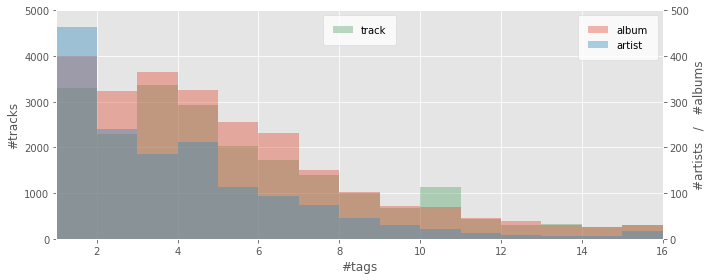

In [505]:
# Tags.
fig, ax1 = plt.subplots(figsize=(10, 4))
ax2 = ax1.twinx()

d = tracks['track', 'tags'].apply(len)
print(d.min(), d.max())
d = d[(d.values >= 1) & (d.values <= 16)]
color = sns.color_palette('deep', 3)[2]
sns.distplot(d, kde=False, bins=d.max()-d.min(), label='track', ax=ax1, color=color)

d = tracks.drop_duplicates(('album', 'id'))
d = d['album', 'tags'].apply(len)
print(d.min(), d.max())
d = d[(d.values >= 1) & (d.values <= 16)]
sns.distplot(d, kde=False, bins=d.max()-d.min(), label='album', ax=ax2)

d = tracks.drop_duplicates(('artist', 'id'))
d = d['artist', 'tags'].apply(len) - 1
print(d.min(), d.max())
d = d[(d.values >= 1) & (d.values <= 16)]
sns.distplot(d, kde=False, bins=d.max()-d.min(), label='artist', ax=ax2)

ax1.set_xlabel('#tags')
ax1.set_ylabel('#tracks')
ax2.set_ylabel('#artists   /   #albums')
ax1.set_xlim(d.min(), d.max())
ax1.set_ylim(0, 5000)
ax2.set_ylim(0, 500)
ax1.legend(loc='upper center')
ax2.legend(loc='upper right')
ax2.grid(False)

plt.tight_layout()
#plt.savefig('tag_distribution.pdf')

In [68]:
# One artist tag is often the artist name.
col = 'artist'
d = tracks.drop_duplicates((col, 'id'))
d.loc[d[col, 'tags'].apply(len) > 0, [('artist', 'name'), (col, 'tags')]].head()

artist                                                   
                name                                               tags
track_id                                                               
2               AWOL                                             [awol]
10         Kurt Vile                                [philly, kurt vile]
20        Nicky Cook  [instrumentals, experimental pop, post punk, e...
135         Abominog                                         [abominog]
137           Airway                                           [airway]

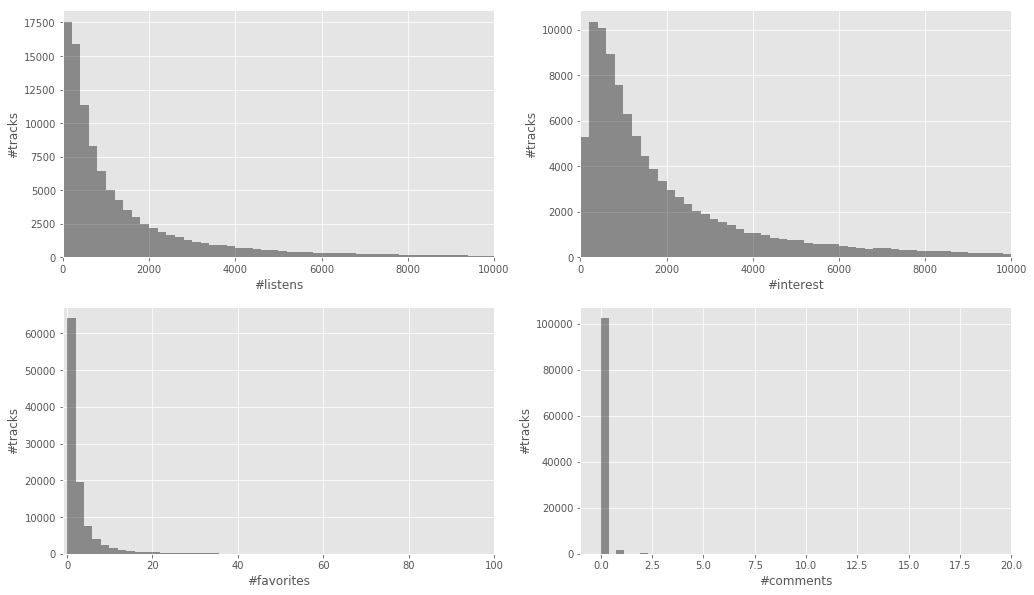

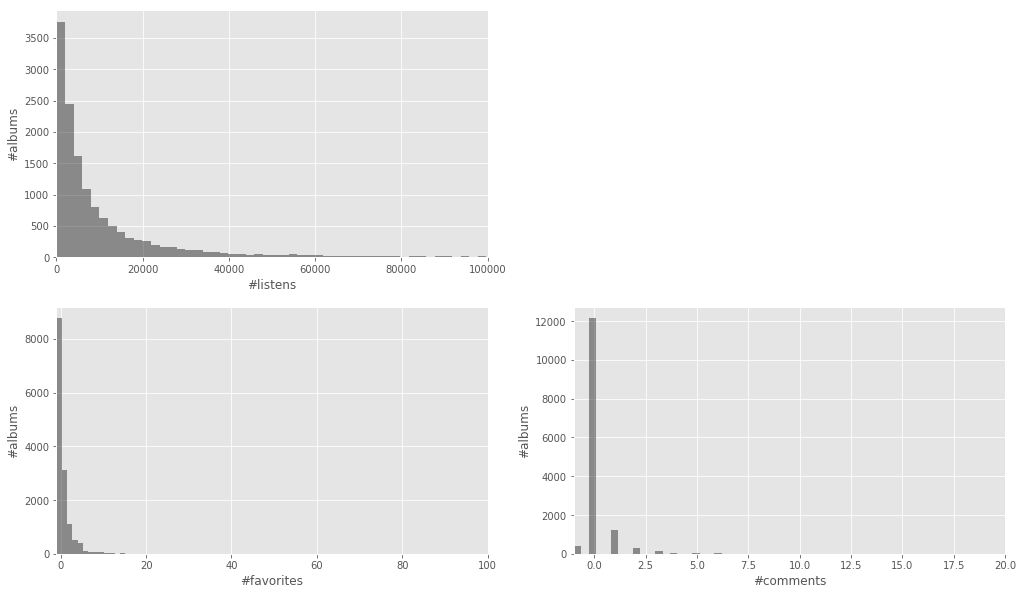

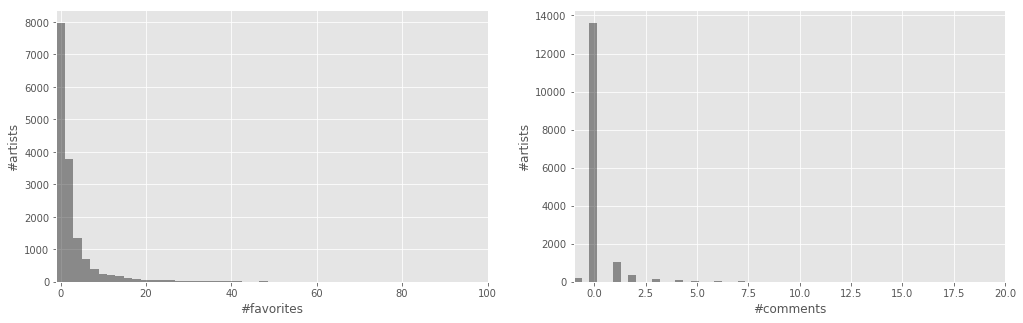

In [517]:
# Listens, favorites, comments.

def plot(col0, col1, maxval, subplot=None):
    if col0 == 'track':
        d = tracks['track']
    if col0 in ['artist', 'album']:
        d = tracks[col0].drop_duplicates('id')
    if subplot:
        plt.subplot(subplot)
    d = d[col1]
    p = sns.distplot(d[d.values < maxval], kde=False, color='k', hist_kws=dict(alpha=0.4))
    p.set_xlim(-1, maxval)
    p.set_xlabel('#' + col1)
    p.set_ylabel('#' + col0 + 's')

plt.figure(figsize=(17, 10))
plot('track', 'listens', 10e3, 221)
plot('track', 'interest', 10e3, 222)
plot('track', 'favorites', 100, 223)
plot('track', 'comments', 20, 224)

plt.figure(figsize=(17, 10))
plot('album', 'listens', 100e3, 221)
plot('album', 'favorites', 100, 223)
plot('album', 'comments', 20, 224)

plt.figure(figsize=(17, 5))
plot('artist', 'favorites', 100, 121)
plot('artist', 'comments', 20, 122)

1553769

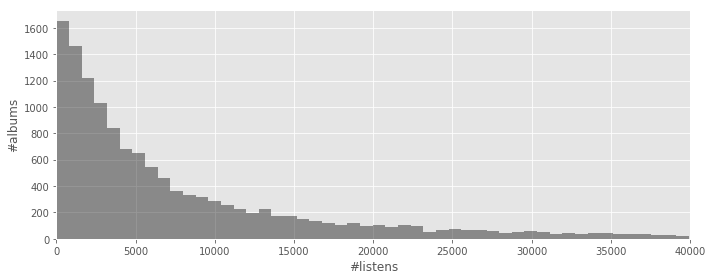

In [518]:
# Same as above, formated for the paper.
plt.figure(figsize=(10, 4))
plot('album', 'listens', 40e3)
plt.tight_layout()
tracks['album', 'listens'].max()

In [52]:
# Most listened albums.
tracks['album'].groupby('id').first().sort_values('listens', ascending=False).head(10)

comments        date_created date_released engineer  favorites  \
id                                                                      
14586        10 2013-07-03 11:51:03    2013-06-28      NaN         55   
15736        13 2013-12-30 16:53:43    2014-01-02      NaN         60   
9870          6 2011-08-17 15:18:08           NaT      NaN         31   
9615          1 2011-07-15 11:52:14           NaT      NaN         17   
10052         5 2011-09-14 19:41:50    2009-09-22      NaN         25   
11948         3 2012-06-17 23:19:50    2012-06-18      NaN         19   
10927        11 2012-01-25 21:36:45    2012-01-25      NaN         54   
10490         0 2011-11-29 11:55:02    2011-12-01      NaN         10   
20211         5 2016-03-28 16:57:28           NaT      NaN         20   
18279         1 2015-05-14 17:38:16           NaT      NaN         10   

                                             information  listens producer  \
id                                                                           
14586  <p>29 funky chiptunes from the soundtrack of "...  1553769      NaN   
15736  <p>Zabriskie’s move toward the likes of Cage, ...  1363291      NaN   
9870   <p>Jason Shaw's music is a great resource for ...  1282752      NaN   
9615   <p>A collection of classical tracks recorded b...  1193803      NaN   
10052  <p>Twenty-three improvised preludes for solo p...  1013245      NaN   
11948                                                NaN   832311      NaN   
10927                                                NaN   808928      NaN   
10490  <p>DUBLAB “BONUS BEAT BLAST” – A CREATIVE COMM...   808021      NaN   
20211  <p>Compositions for commercial use. Uplifiting...   795319      NaN   
18279  <p>An ecclectic collection of instrumental mus...   754578      NaN   

                                                    tags  \
id                                                         
14586                                                 []   
15736                                            [piano]   
9870      [1outro, tracks to sync, piano, soft, strings]   
9615   [1dance, erik satie, strauss, satie, beethoven...   
10052                                            [piano]   
11948         [electronic, new age, space, instrumental]   
10927                  [piano, instrumental, melancholy]   
10490                                                 []   
20211                                                 []   
18279                                                 []   

                                      title  tracks   type  
id                                                          
14586  Nameless: The Hackers RPG Soundtrack      29  Album  
15736                             Cylinders      18  Album  
9870                  Audionautix: Acoustic      40  Album  
9615                      Classical Sampler      59  Album  
10052                              Preludes      23  Album  
11948                              Reappear       7  Album  
10927          Undercover Vampire Policeman       8  Album  
10490                 Bonus Beat Blast 2011      74  Album  
20211                            Commercial      36  Album  
18279                      Production Music      29  Album

### 2.3 Dates

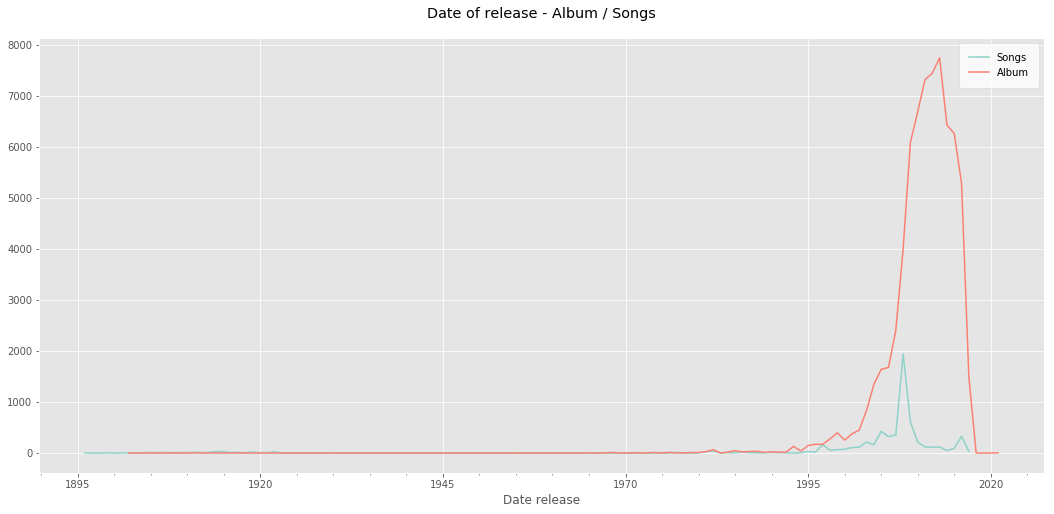

In [507]:
def plot(col0, col1, color):
    if col0 == 'track':
        d = tracks['track']
    if col0 in ['artist', 'album']:
        d = tracks[col0]
    d = pd.Series(1, index=d[col1])
    d.resample('A').sum().fillna(0).plot(color=pallete_colors(color))

plt.figure()
plot('track', 'date_recorded', 0)
plot('album', 'date_released', 4)
plt.title("Date of release - Album / Songs", pad=20)
plt.xlabel("Date release")
plt.legend(labels=['Songs', 'Album']);
plt.savefig('graphs/date_release.png')

## 3 Artists & albums effect

In [55]:
counts = pd.Series(index=genres.loc[genres['parent'] == 0, 'title'].values, name='artists')
for genre in counts.index:
    counts[genre] = len(tracks.loc[tracks['track',
                                          'genre_top'] == genre,
                                   ('artist', 'id')].unique())


counts = pd.DataFrame(counts.sort_values(ascending=False))
counts.reset_index(level=0, inplace=True)
counts

index  artists
0          Experimental   5558.0
1                  Rock   3298.0
2            Electronic   3121.0
3                   Pop   1117.0
4          Instrumental   1099.0
5                  Folk    744.0
6         International    721.0
7               Hip-Hop    623.0
8   Old-Time / Historic    406.0
9             Classical    292.0
10                 Jazz    227.0
11               Spoken    205.0
12             Soul-RnB    202.0
13              Country    192.0
14       Easy Listening     86.0
15                Blues     84.0

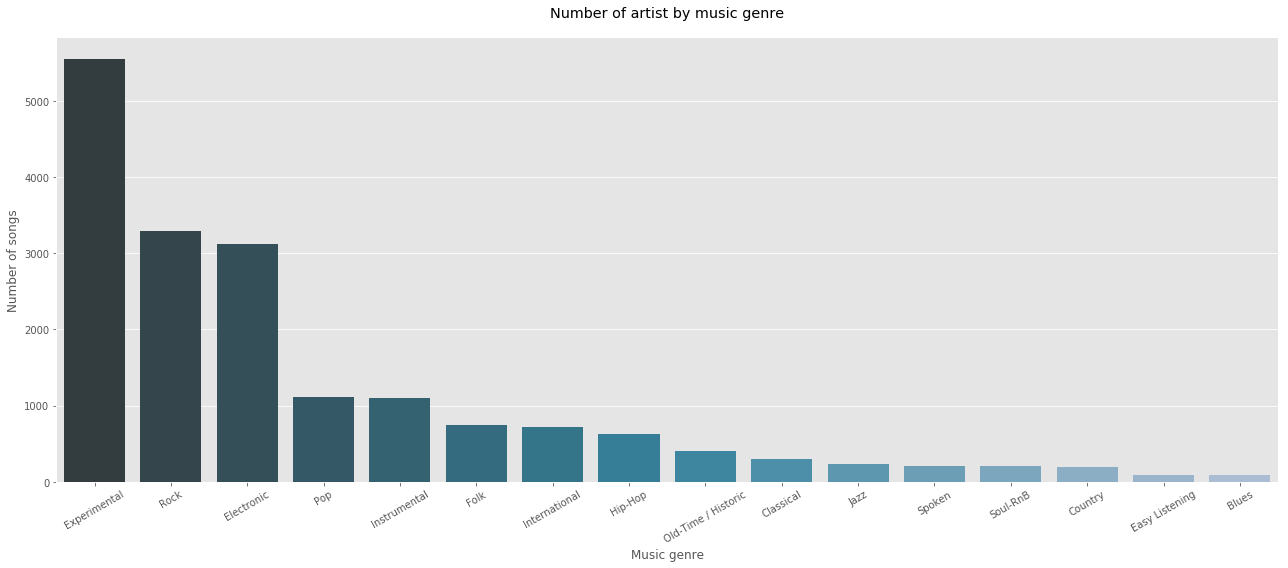

In [508]:
plt.title("Artist by music genre", pad=20)
plt.xlabel('Music Genre')
plt.ylabel('Artists');


g = sns.barplot(counts['index'], counts['artists'], palette=("PuBuGn_d"))
g.set_xticklabels(rotation=30, labels=counts['index'])
g.set(xlabel='Music genre', ylabel='Number of songs')
g.set_title('Number of artist by music genre', pad=20)
g.get_figure().tight_layout()
g.get_figure().savefig('graphs/artists-genre.png')

## 4 Genres

In [57]:
a = set(tracks['track', 'genre_top'].unique().dropna())
b = set(genres.loc[genres['top_level'].unique(), 'title'].values)
assert a == b

print('{} top-level genres'.format(len(a)))
genres[genres['parent'] == 0].sort_values('#tracks', ascending=False)

16 top-level genres


#tracks  parent                title  top_level
genre_id                                                 
38          38154       0         Experimental         38
15          34413       0           Electronic         15
12          32923       0                 Rock         12
1235        14938       0         Instrumental       1235
10          13845       0                  Pop         10
17          12706       0                 Folk         17
21           8389       0              Hip-Hop         21
2            5271       0        International          2
4            4126       0                 Jazz          4
5            4106       0            Classical          5
9            1987       0              Country          9
20           1876       0               Spoken         20
3            1752       0                Blues          3
14           1499       0             Soul-RnB         14
8             868       0  Old-Time / Historic          8
13            730       0       Easy Listening         13

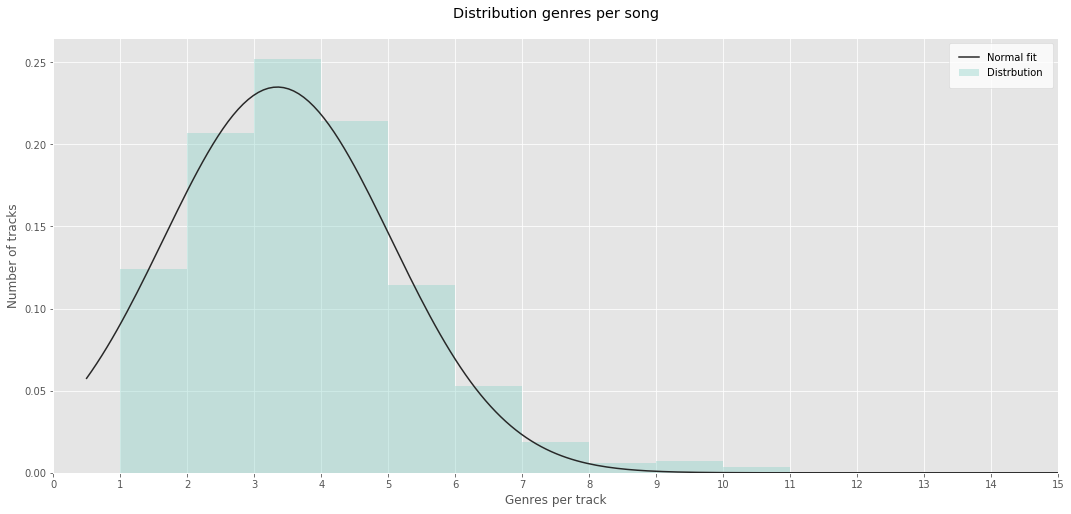

In [17]:
# Same as above, formatted for the paper.
d = tracks['track', 'genres_all'].map(len)
g = sns.distplot(d[d.values <= 15], kde=False, bins=range(12),
                 color=pallete_colors(1), hist_kws=dict(alpha=0.4), fit=norm)
g.set_title("Distribution genres per song", pad=20)
g.set_xlabel('Genres per track')
g.set_ylabel('% of tracks');
g.set_xlim(0, 15)
g.set_xticks(range(16));
g.legend(labels=['Normal fit', 'Distrbution'])

plt.savefig('graphs/genres_per_track.png')

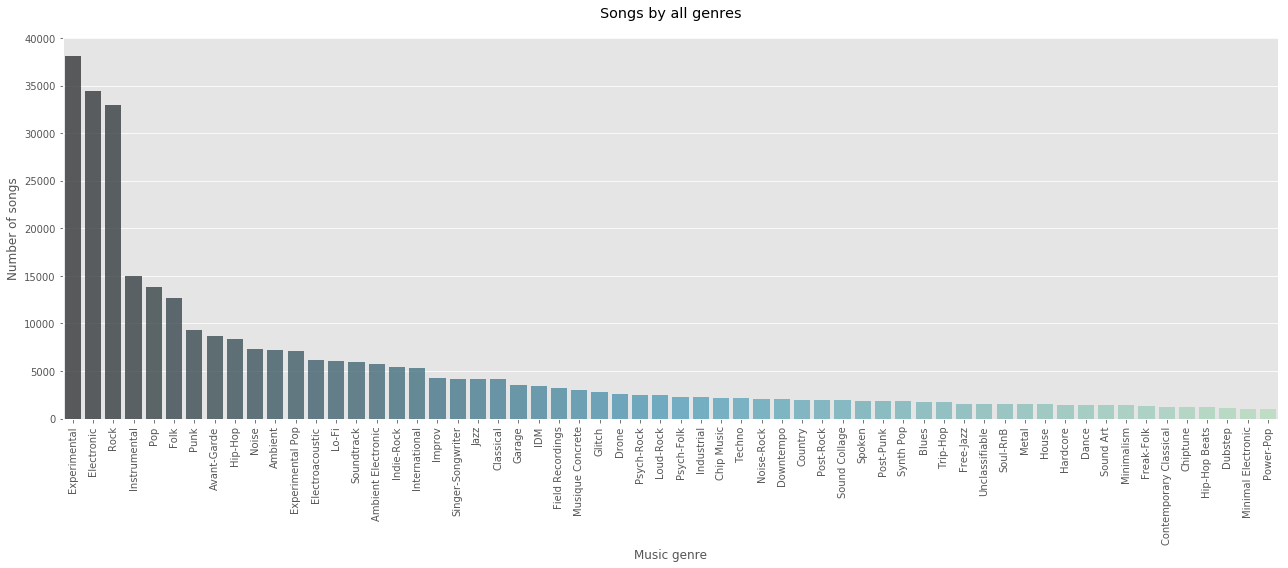

In [512]:
# Number of tracks per genre (full).
d = genres[genres['#tracks'] > 1000].sort_values('#tracks', ascending=False)
g = sns.barplot('title', '#tracks', data=d, palette="GnBu_d", alpha=0.8)
g.set_title("Songs by all genres", pad=20)
g.set_xlabel('Music genre')
g.set_ylabel('Number of songs')
plt.xticks(rotation=90)
plt.tight_layout()

plt.savefig('graphs/allgenres_distribution.png')

### 4.1 Genre hierarchy

* As genres have parent genres, we can plot a tree using the [DOT] language.
* Save the full genre tree as a PDF.

Todo:
* Color nodes according to FMA genre color.
* Better looking tree.

[DOT]: https://en.wikipedia.org/wiki/DOT_(graph_description_language)

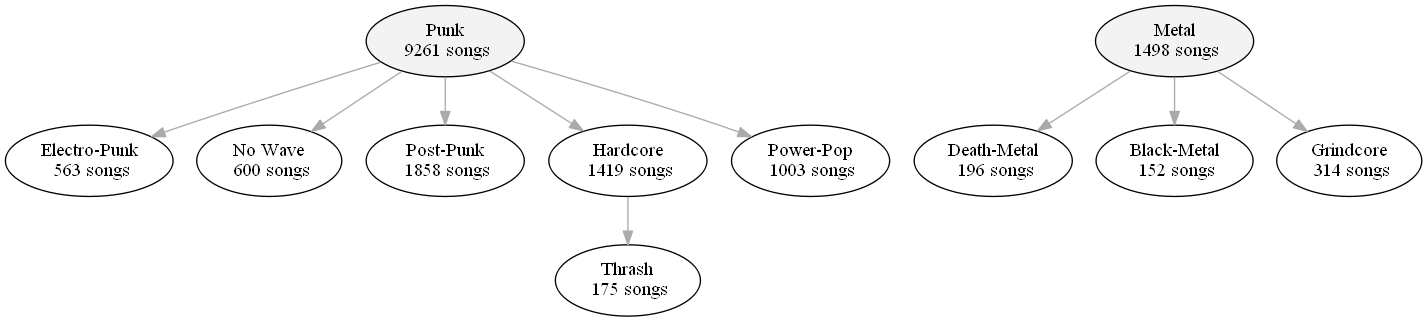

In [121]:
import importlib
importlib.reload(utils)
  
g = utils.Genres(genres)
graph = g.create_tree([25, 31], 2)
ipd.Image(graph.create_png())

In [122]:
# Genereting all parent trees
tree_genres = genres.loc[g.find_roots()]
for idx, genre in tree_genres.iterrows():
    graph = g.create_tree(idx)
    cg = re.sub(r'\W+', '', genre['title'].lower())
    graph.write_png(f"graphs/genres-trees/genre_hierarchy_{cg}.png");

### 4.2 Cross-appearance

* Group rows and columns for better identification of related genres.

In [62]:
enc = sklearn.preprocessing.MultiLabelBinarizer()
genres_indicator = enc.fit_transform(tracks['track', 'genres_all'])
genres_names = enc.classes_
genres_names = genres.loc[enc.classes_, 'title'].values
cross_correlation = genres_indicator.T @ genres_indicator

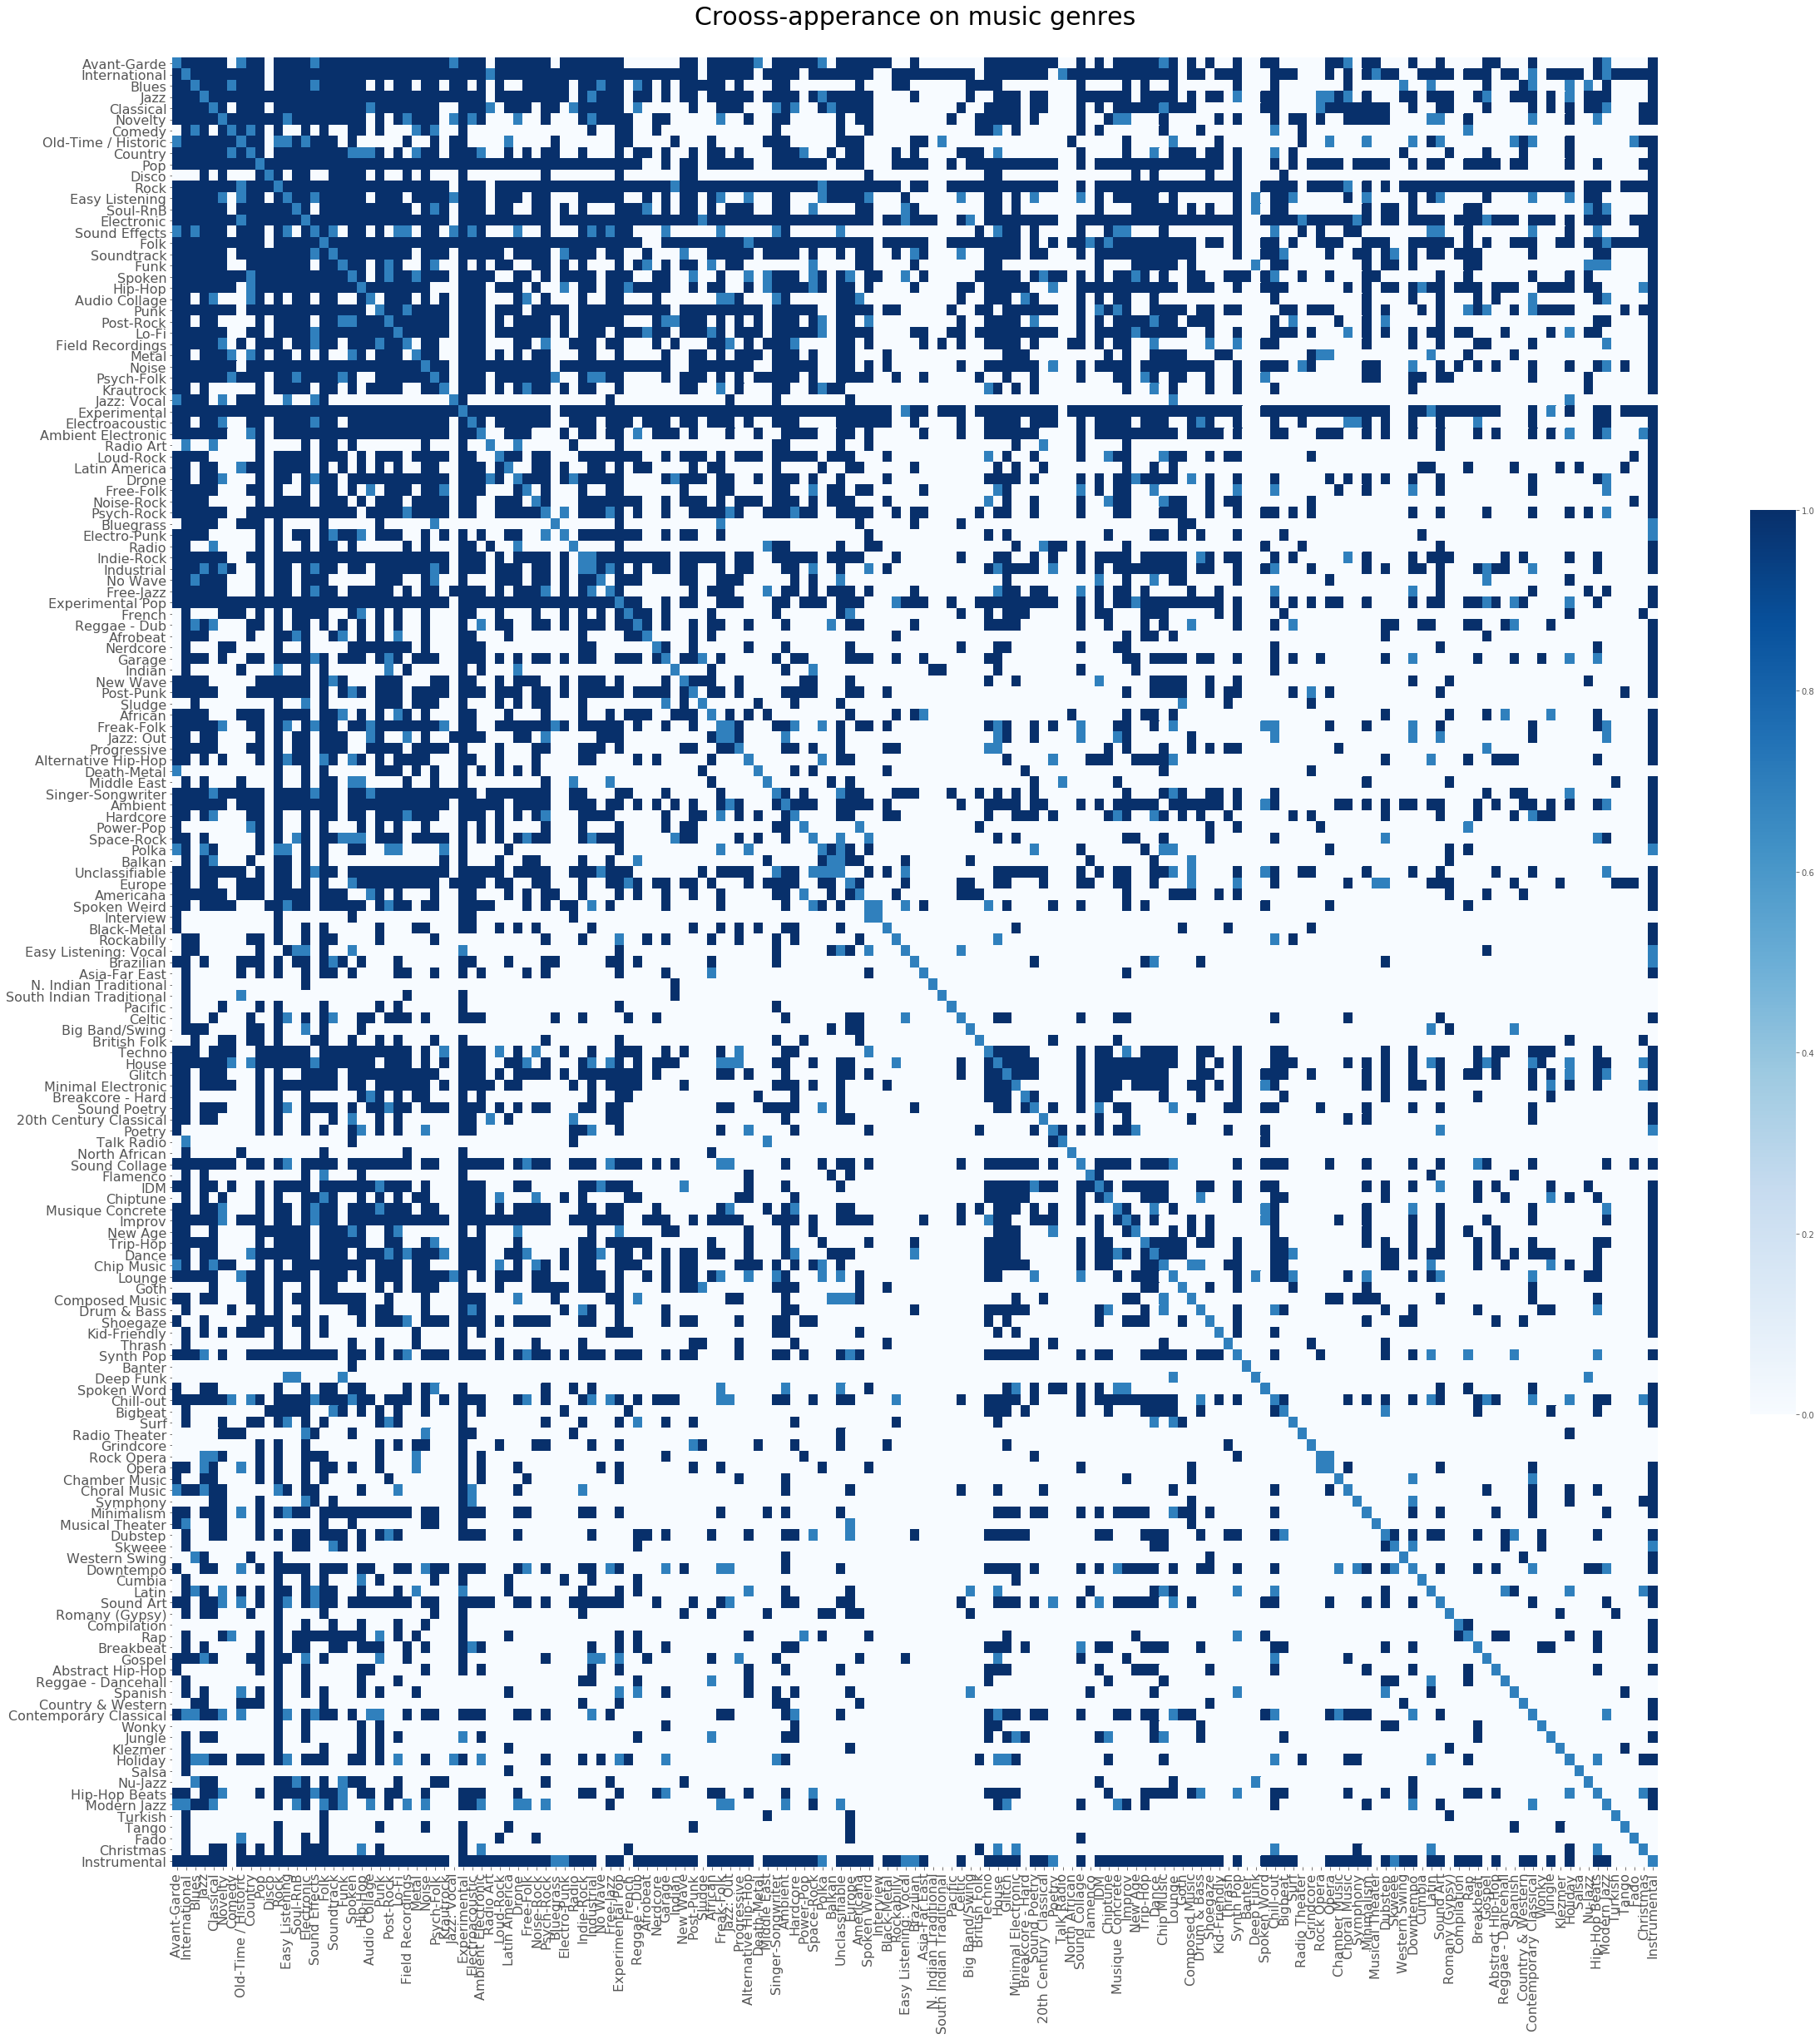

In [448]:
np.fill_diagonal(cross_correlation, 1)
plt.figure(figsize=(40, 40))

g = sns.heatmap(np.log1p(cross_correlation), cmap="Blues",
                vmin=0, vmax=1,cbar_kws={"shrink": 0.5})

g.set_title("Crooss-apperance on music genres", pad=40, fontsize=30)
g.set_yticklabels(labels=genres_names, fontsize=16)
g.set_xticklabels(labels=genres_names, fontsize=16, rotation=90)

#plt.tight_layout()
plt.savefig('graphs/genres_correaltion.png')

## 5 Features

Todo: understand features by listening to segments who have them, e.g. <http://musicinformationretrieval.com/feature_sonification.html>.

In [64]:
features.head(5).style.format('{:.2f}')

### Some features are discriminant.

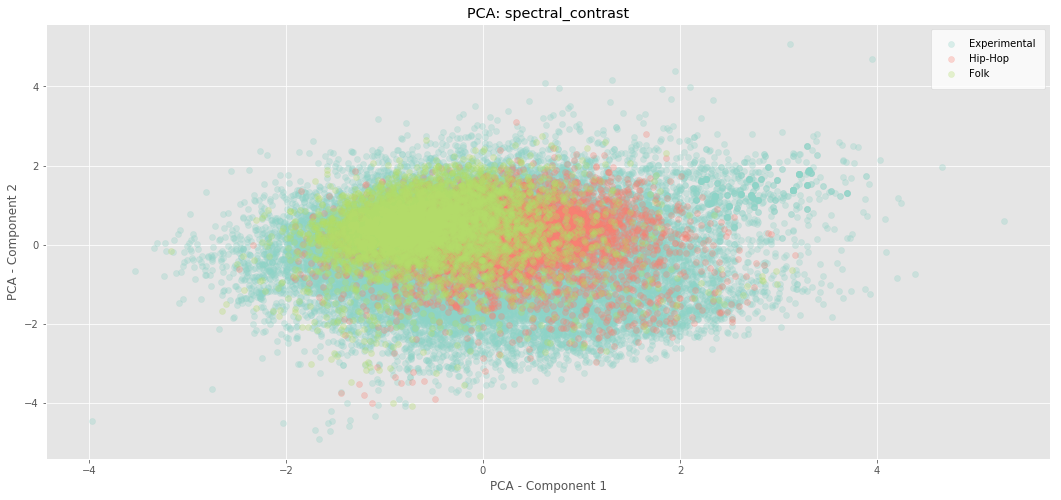

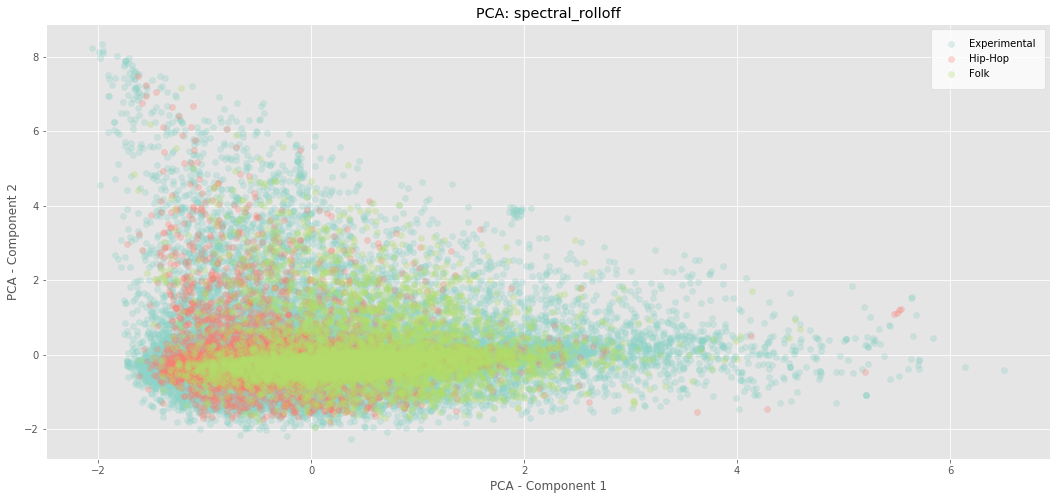

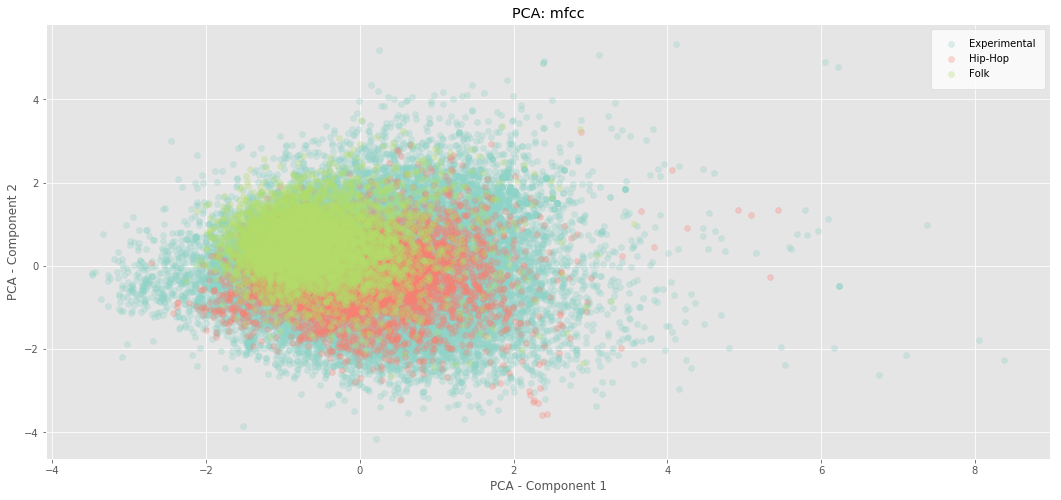

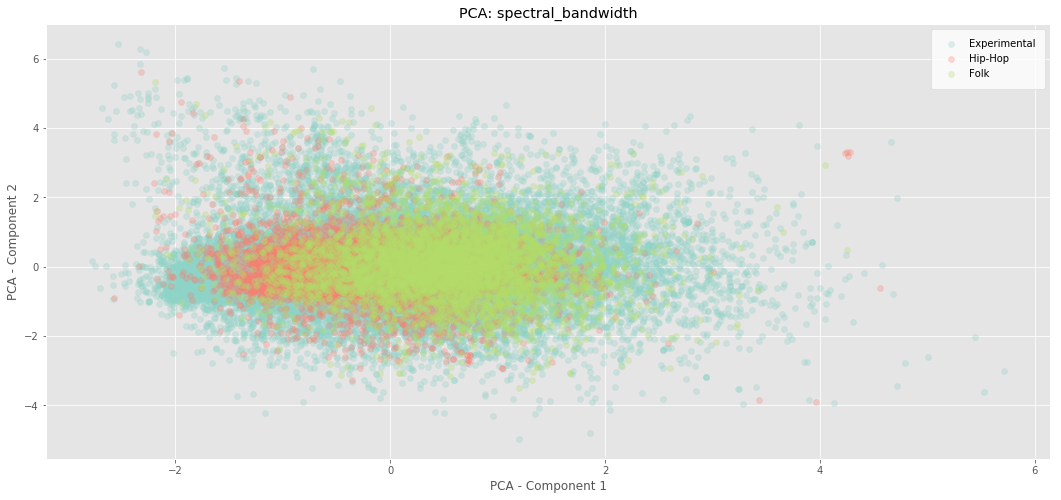

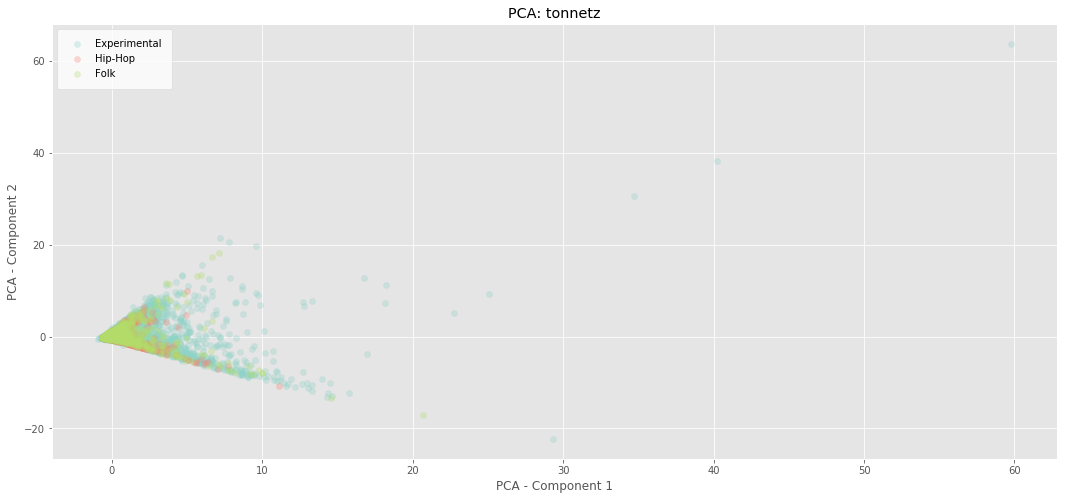

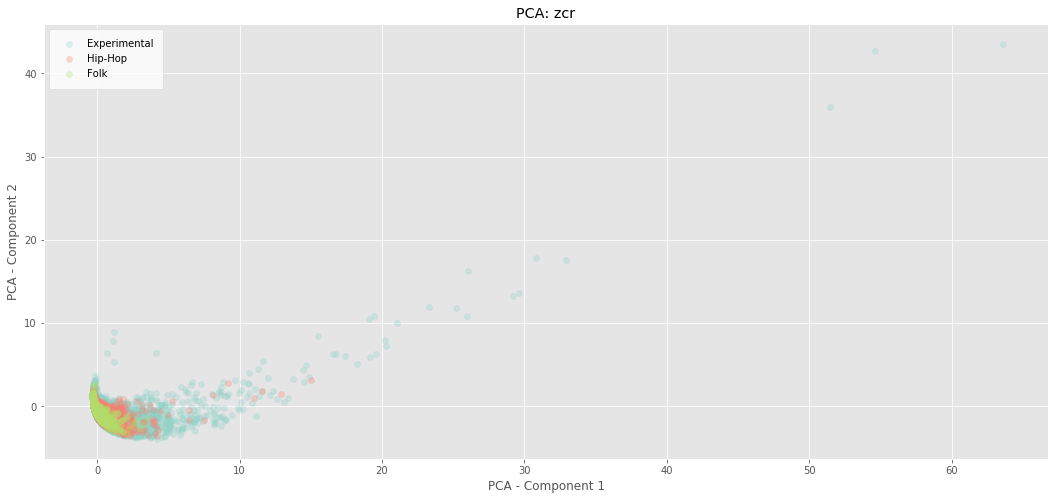

In [513]:
large = tracks['set', 'subset'] <= subset_size
genres_plot = {0: "Experimental", 1: "Hip-Hop", 2:"Folk"}
genre1 = tracks['track', 'genre_top'] == genres_plot[0]
genre2 = tracks['track', 'genre_top'] == genres_plot[1]
genre3 = tracks['track', 'genre_top'] == genres_plot[2]

set3 = cm.get_cmap('Set3', 5)

# Features to plot
features_plot = ["spectral_contrast", "spectral_rolloff",
                 "mfcc", "spectral_bandwidth", "tonnetz", "zcr"]

y = tracks.loc[large & (genre1 | genre2 | genre3), ('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

for feature in features_plot:

    X = features.loc[large & (genre1 | genre2| genre3), feature]
    X = skl.decomposition.PCA(n_components=2, whiten=True).fit_transform(X)

    # Plot by genre
    fig, ax = plt.subplots()
    for g in np.unique(y):
        ix = np.where(y == g)
        ax.scatter(X[ix, 0], X[ix, 1],
                   c=set3(g), label=genres_plot[g],
                   alpha=0.3)
    ax.legend()
    plt.title("PCA: " + feature)
    plt.xlabel("PCA - Component 1")
    plt.ylabel("PCA - Component 2")
    plt.legend(loc='best')
    plt.savefig(f'graphs/pca_{feature}.png')

    plt.show()

### Inter and Outer Correlation

We are looking for correlation in different times of momentus of a feature, or between them.

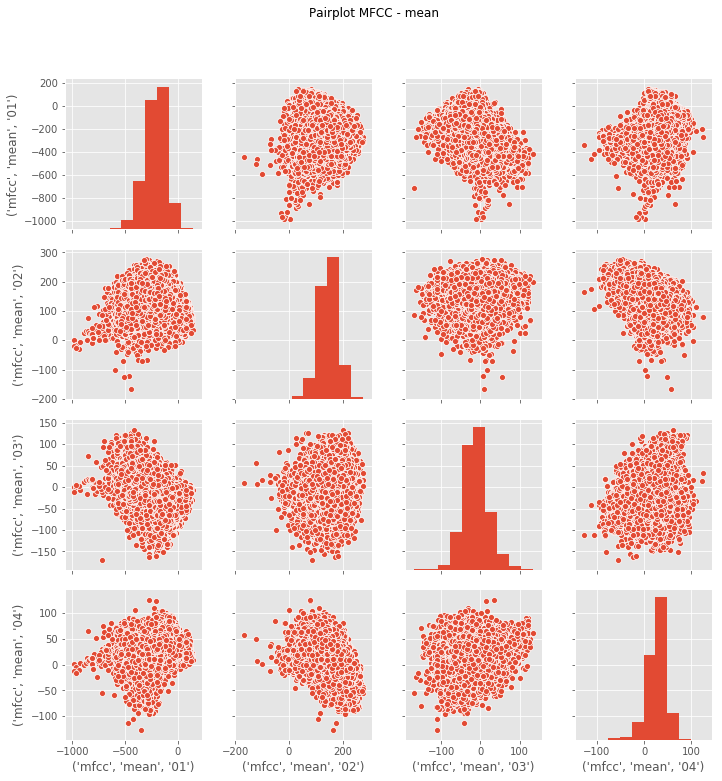

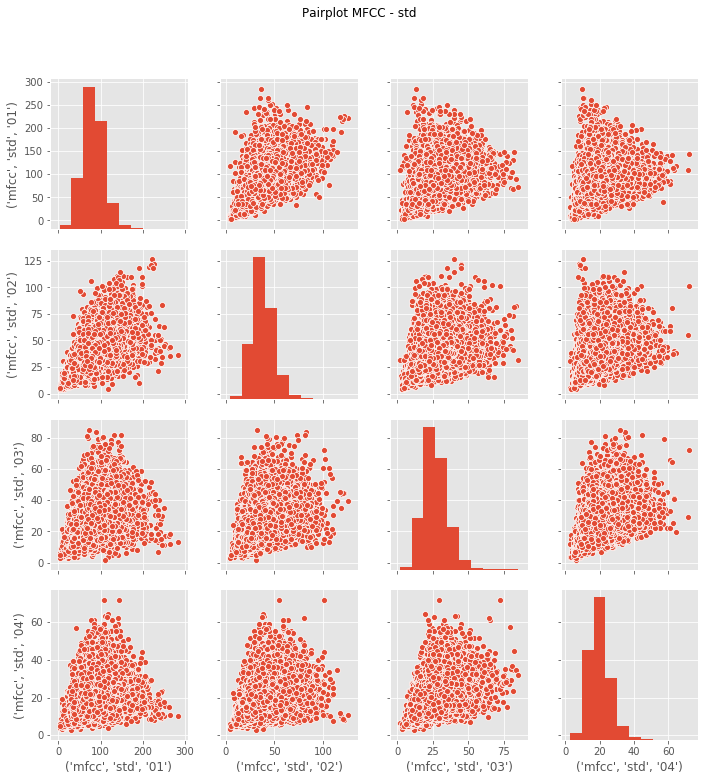

In [450]:
g = sns.pairplot(features.loc[:, ('mfcc', 'mean', slice('01','04'))])
g.fig.suptitle("Pairplot MFCC - mean", y=1.08);
g = sns.pairplot(features.loc[:, ('mfcc', 'std', slice('01','04'))])
g.fig.suptitle("Pairplot MFCC - std", y=1.08);

In [406]:
# Filtering all perfect correlations, sum by row, su total
cor_mat = features.corr()

# If grather than number of features, there are some perfect correlations
if(cor_mat.shape[0] == cor_mat[cor_mat==1].notna().sum().sum()):
    print ("There are not perfect correaltions.")

There are not perfect correaltions.
